In [77]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import tensorflow as tf
from tensorflow import keras
from keras import layers
from sklearn import preprocessing
from sklearn import model_selection

from google.colab import drive
drive.mount("/content/gdrive")

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [78]:
df = pd.read_csv("/content/gdrive/My Drive/datasets/cleaned_soccer_data_2016_v3.csv", index_col=0)
df.head()

,id,player_fifa_api_id,player_api_id,date,overall_rating,potential,crossing,finishing,heading_accuracy,short_passing,volleys,dribbling,curve,free_kick_accuracy,long_passing,ball_control,acceleration,sprint_speed,agility,reactions,balance,shot_power,jumping,stamina,strength,long_shots,aggression,interceptions,positioning,vision,penalties,marking,standing_tackle,sliding_tackle,gk_diving,gk_handling,gk_kicking,gk_positioning,gk_reflexes,player_positions,ls,st,rs,lw,lf,cf,rf,rw,lam,cam,ram,lm,lcm,cm,rcm,rm,lwb,ldm,cdm,rdm,rwb,lb,lcb,cb,rcb,rb,player_name,height,weight,preferred_foot_left,preferred_foot_right,attacking_work_rate_high,attacking_work_rate_low,attacking_work_rate_medium,defensive_work_rate_high,defensive_work_rate_low,defensive_work_rate_medium,player_positions_general
0,1,218353,505942,2016-02-18,67.0,71.0,49.0,44.0,71.0,61.0,44.0,51.0,45.0,39.0,64.0,49.0,60.0,64.0,59.0,47.0,65.0,55.0,58.0,54.0,76.0,35.0,71.0,70.0,45.0,54.0,48.0,65.0,69.0,69.0,6.0,11.0,10.0,8.0,8.0,CB,53,53,53,51,51,51,51,51,52,52,52,53,53,53,53,53,56,58,58,58,56,58,62,62,62,58,Aaron Appindangoye,182.88,187,0,1,0,0,1,0,0,1,DEF
1,6,189615,155782,2016-04-21,74.0,76.0,80.0,53.0,58.0,71.0,40.0,73.0,70.0,69.0,68.0,71.0,79.0,78.0,78.0,67.0,90.0,71.0,85.0,79.0,56.0,62.0,68.0,67.0,60.0,66.0,59.0,76.0,75.0,78.0,14.0,7.0,9.0,9.0,12.0,LB,62,62,62,67,65,65,65,67,66,66,66,69,67,67,67,69,74,70,70,70,74,73,69,69,69,73,Aaron Cresswell,170.18,146,1,0,1,0,0,0,0,1,DEF
2,65,140161,30572,2016-04-21,69.0,69.0,57.0,21.0,68.0,65.0,48.0,56.0,38.0,40.0,61.0,62.0,33.0,34.0,62.0,57.0,41.0,59.0,71.0,49.0,90.0,29.0,70.0,62.0,26.0,54.0,37.0,72.0,71.0,68.0,15.0,12.0,13.0,12.0,11.0,"CB, RB",48,48,48,48,47,47,47,48,51,51,51,50,56,56,56,50,59,65,65,65,59,60,69,69,69,60,Aaron Galindo,182.88,198,0,1,0,0,1,0,0,1,DEF
3,88,17725,23780,2015-12-24,70.0,70.0,46.0,34.0,73.0,65.0,33.0,47.0,42.0,25.0,58.0,58.0,33.0,31.0,41.0,68.0,52.0,48.0,67.0,60.0,75.0,26.0,66.0,68.0,29.0,41.0,45.0,75.0,73.0,71.0,8.0,6.0,16.0,12.0,11.0,CB,48,48,48,45,46,46,46,45,48,48,48,48,55,55,55,48,60,66,66,66,60,62,70,70,70,62,Aaron Hughes,182.88,154,0,1,0,0,1,0,0,1,DEF
4,113,158138,27316,2016-04-28,77.0,77.0,77.0,72.0,64.0,79.0,77.0,78.0,77.0,76.0,70.0,79.0,75.0,69.0,76.0,80.0,72.0,76.0,65.0,75.0,65.0,76.0,59.0,55.0,77.0,76.0,81.0,28.0,34.0,35.0,15.0,12.0,7.0,16.0,15.0,"CAM, CM, LM",75,75,75,78,77,77,77,78,78,78,78,78,73,73,73,78,63,64,64,64,63,59,53,53,53,59,Aaron Hunt,182.88,161,1,0,0,0,1,0,0,1,MID


In [79]:
# drop useless columns and save them in a separate dataframe to be merged later

nominal_cols = ['id','player_fifa_api_id','player_api_id','date','player_name','player_positions']
nominal_cols_w_general_position = ['id','player_fifa_api_id','player_api_id','date','player_name','player_positions','player_positions_general']
df_nominal = df[nominal_cols_w_general_position]
df.drop(columns=nominal_cols,inplace=True)
df.head()

,overall_rating,potential,crossing,finishing,heading_accuracy,short_passing,volleys,dribbling,curve,free_kick_accuracy,long_passing,ball_control,acceleration,sprint_speed,agility,reactions,balance,shot_power,jumping,stamina,strength,long_shots,aggression,interceptions,positioning,vision,penalties,marking,standing_tackle,sliding_tackle,gk_diving,gk_handling,gk_kicking,gk_positioning,gk_reflexes,ls,st,rs,lw,lf,cf,rf,rw,lam,cam,ram,lm,lcm,cm,rcm,rm,lwb,ldm,cdm,rdm,rwb,lb,lcb,cb,rcb,rb,height,weight,preferred_foot_left,preferred_foot_right,attacking_work_rate_high,attacking_work_rate_low,attacking_work_rate_medium,defensive_work_rate_high,defensive_work_rate_low,defensive_work_rate_medium,player_positions_general
0,67.0,71.0,49.0,44.0,71.0,61.0,44.0,51.0,45.0,39.0,64.0,49.0,60.0,64.0,59.0,47.0,65.0,55.0,58.0,54.0,76.0,35.0,71.0,70.0,45.0,54.0,48.0,65.0,69.0,69.0,6.0,11.0,10.0,8.0,8.0,53,53,53,51,51,51,51,51,52,52,52,53,53,53,53,53,56,58,58,58,56,58,62,62,62,58,182.88,187,0,1,0,0,1,0,0,1,DEF
1,74.0,76.0,80.0,53.0,58.0,71.0,40.0,73.0,70.0,69.0,68.0,71.0,79.0,78.0,78.0,67.0,90.0,71.0,85.0,79.0,56.0,62.0,68.0,67.0,60.0,66.0,59.0,76.0,75.0,78.0,14.0,7.0,9.0,9.0,12.0,62,62,62,67,65,65,65,67,66,66,66,69,67,67,67,69,74,70,70,70,74,73,69,69,69,73,170.18,146,1,0,1,0,0,0,0,1,DEF
2,69.0,69.0,57.0,21.0,68.0,65.0,48.0,56.0,38.0,40.0,61.0,62.0,33.0,34.0,62.0,57.0,41.0,59.0,71.0,49.0,90.0,29.0,70.0,62.0,26.0,54.0,37.0,72.0,71.0,68.0,15.0,12.0,13.0,12.0,11.0,48,48,48,48,47,47,47,48,51,51,51,50,56,56,56,50,59,65,65,65,59,60,69,69,69,60,182.88,198,0,1,0,0,1,0,0,1,DEF
3,70.0,70.0,46.0,34.0,73.0,65.0,33.0,47.0,42.0,25.0,58.0,58.0,33.0,31.0,41.0,68.0,52.0,48.0,67.0,60.0,75.0,26.0,66.0,68.0,29.0,41.0,45.0,75.0,73.0,71.0,8.0,6.0,16.0,12.0,11.0,48,48,48,45,46,46,46,45,48,48,48,48,55,55,55,48,60,66,66,66,60,62,70,70,70,62,182.88,154,0,1,0,0,1,0,0,1,DEF
4,77.0,77.0,77.0,72.0,64.0,79.0,77.0,78.0,77.0,76.0,70.0,79.0,75.0,69.0,76.0,80.0,72.0,76.0,65.0,75.0,65.0,76.0,59.0,55.0,77.0,76.0,81.0,28.0,34.0,35.0,15.0,12.0,7.0,16.0,15.0,75,75,75,78,77,77,77,78,78,78,78,78,73,73,73,78,63,64,64,64,63,59,53,53,53,59,182.88,161,1,0,0,0,1,0,0,1,MID


In [80]:
# check if all data is numerical

print(df.dtypes)

overall_rating                float64
potential                     float64
crossing                      float64
finishing                     float64
heading_accuracy              float64
                               ...   
attacking_work_rate_medium      int64
defensive_work_rate_high        int64
defensive_work_rate_low         int64
defensive_work_rate_medium      int64
player_positions_general       object
Length: 72, dtype: object


In [81]:
# perform OHE on player_positions_general column

temp = pd.get_dummies(df['player_positions_general'])
df_preprocessed = pd.concat([df,temp], axis=1)
df_preprocessed.drop(columns='player_positions_general',inplace=True)

In [82]:
# normalize data using MinMaxScaler

scaler = preprocessing.MinMaxScaler()

df_preprocessed = pd.DataFrame(scaler.fit_transform(df_preprocessed), columns=df_preprocessed.columns)
df_preprocessed.head()

,overall_rating,potential,crossing,finishing,heading_accuracy,short_passing,volleys,dribbling,curve,free_kick_accuracy,long_passing,ball_control,acceleration,sprint_speed,agility,reactions,balance,shot_power,jumping,stamina,strength,long_shots,aggression,interceptions,positioning,vision,penalties,marking,standing_tackle,sliding_tackle,gk_diving,gk_handling,gk_kicking,gk_positioning,gk_reflexes,ls,st,rs,lw,lf,cf,rf,rw,lam,cam,ram,lm,lcm,cm,rcm,rm,lwb,ldm,cdm,rdm,rwb,lb,lcb,cb,rcb,rb,height,weight,preferred_foot_left,preferred_foot_right,attacking_work_rate_high,attacking_work_rate_low,attacking_work_rate_medium,defensive_work_rate_high,defensive_work_rate_low,defensive_work_rate_medium,ATK,DEF,GK,MID
0,0.413043,0.465116,0.494118,0.426966,0.724138,0.617284,0.448276,0.488636,0.453488,0.388889,0.650602,0.453488,0.559524,0.619048,0.520000,0.224138,0.607595,0.529412,0.493151,0.517647,0.714286,0.333333,0.722892,0.735632,0.461538,0.518072,0.448276,0.712644,0.741176,0.711111,0.057471,0.116279,0.100000,0.078652,0.078652,0.582418,0.582418,0.582418,0.560440,0.560440,0.560440,0.560440,0.560440,0.571429,0.571429,0.571429,0.588889,0.623529,0.623529,0.623529,0.588889,0.643678,0.682353,0.682353,0.682353,0.643678,0.674419,0.720930,0.720930,0.720930,0.674419,0.529412,0.521368,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
1,0.565217,0.581395,0.858824,0.528090,0.574713,0.740741,0.402299,0.738636,0.744186,0.722222,0.698795,0.709302,0.785714,0.785714,0.773333,0.568966,0.924051,0.717647,0.863014,0.811765,0.428571,0.643678,0.686747,0.701149,0.626374,0.662651,0.574713,0.839080,0.811765,0.811111,0.149425,0.069767,0.088889,0.089888,0.123596,0.681319,0.681319,0.681319,0.736264,0.714286,0.714286,0.714286,0.736264,0.725275,0.725275,0.725275,0.766667,0.788235,0.788235,0.788235,0.766667,0.850575,0.823529,0.823529,0.823529,0.850575,0.848837,0.802326,0.802326,0.802326,0.848837,0.235294,0.170940,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
2,0.456522,0.418605,0.588235,0.168539,0.689655,0.666667,0.494253,0.545455,0.372093,0.400000,0.614458,0.604651,0.238095,0.261905,0.560000,0.396552,0.303797,0.576471,0.671233,0.458824,0.914286,0.264368,0.710843,0.643678,0.252747,0.518072,0.321839,0.793103,0.764706,0.700000,0.160920,0.127907,0.133333,0.123596,0.112360,0.527473,0.527473,0.527473,0.527473,0.516484,0.516484,0.516484,0.527473,0.560440,0.560440,0.560440,0.555556,0.658824,0.658824,0.658824,0.555556,0.678161,0.764706,0.764706,0.764706,0.678161,0.697674,0.802326,0.802326,0.802326,0.697674,0.529412,0.615385,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
3,0.478261,0.441860,0.458824,0.314607,0.747126,0.666667,0.321839,0.443182,0.418605,0.233333,0.578313,0.558140,0.238095,0.226190,0.280000,0.586207,0.443038,0.447059,0.616438,0.588235,0.700000,0.229885,0.662651,0.712644,0.285714,0.361446,0.413793,0.827586,0.788235,0.733333,0.080460,0.058140,0.166667,0.123596,0.112360,0.527473,0.527473,0.527473,0.494505,0.505495,0.505495,0.505495,0.494505,0.527473,0.527473,0.527473,0.533333,0.647059,0.647059,0.647059,0.533333,0.689655,0.776471,0.776471,0.776471,0.689655,0.720930,0.813953,0.813953,0.813953,0.720930,0.529412,0.239316,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
4,0.630435,0.604651,0.823529,0.741573,0.643678,0.839506,0.827586,0.795455,0.825581,0.800000,0.722892,0.802326,0.738095,0.678571,0.746667,0.793103,0.696203,0.776471,0.589041,0.764706,0.557143,0.804598,0.578313,0.563218,0.813187,0.783133,0.827586,0.287356,0.329412,0.333333,0.160920,0.127907,0.066667,0.168539,0.157303,0.824176,0.824176,0.824176,0.857143,0.846154,0.846154,0.846154,0.857143,0.857143,0.857143,0.857143,0.866667,0.858824,0.858824,0.858824,0.866667,0.724138,0.752941,0.752941,0.752941,0.724138,0.686047,0.616279,0.616279,0.616279,0.686047,0.529412,0.299145,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0


In [83]:
# define feature and target columns

feature_cols = ['overall_rating', 'potential', 'crossing', 'finishing',
            'heading_accuracy', 'short_passing', 'volleys', 'dribbling', 'curve',
            'free_kick_accuracy', 'long_passing', 'ball_control', 'acceleration',
            'sprint_speed', 'agility', 'reactions', 'balance', 'shot_power',
            'jumping', 'stamina', 'strength', 'long_shots', 'aggression',
            'interceptions', 'positioning', 'vision', 'penalties', 'marking',
            'standing_tackle', 'sliding_tackle', 'gk_diving', 'gk_handling',
            'gk_kicking', 'gk_positioning', 'gk_reflexes', 'height', 'weight', 'preferred_foot_left', 'preferred_foot_right',
            'attacking_work_rate_high', 'attacking_work_rate_low',
            'attacking_work_rate_medium', 'defensive_work_rate_high',
            'defensive_work_rate_low', 'defensive_work_rate_medium'
            ]
target_cols = ['ls', 'st', 'rs', 'lw', 'lf', 'cf', 'rf', 'rw', 'lam', 'cam', 'ram', 'lm', 'lcm', 
              'cm', 'rcm', 'rm', 'lwb', 'ldm', 'cdm', 'rdm', 'rwb', 'lb', 'lcb', 'cb', 'rcb', 'rb'
              ]

In [84]:
# split train and test sets

X_train, X_test, y_train, y_test = model_selection.train_test_split(df_preprocessed[feature_cols], df_preprocessed[target_cols], test_size=0.33)

In [85]:
print(len(feature_cols))
print(len(target_cols))

45
26


In [86]:
# instantiate and fit model

input_dims = len(feature_cols)
output_dims = len(target_cols)

model = keras.Sequential(
    [
     layers.Dense(36, activation='relu', input_shape=(input_dims,), name='first_hidden_layer'),
     layers.Dropout(0.5),
     layers.Dense(32, name='final_hidden_layer'),
     layers.Activation("relu"),
     layers.Dropout(0.5),
     layers.Dense(output_dims, activation='linear'),
    ]
, name='positional_ratings_predictor')

model.compile(optimizer='adam', loss='mae', metrics=['mse'])

model.summary()

history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=100, batch_size=64, callbacks=[keras.callbacks.EarlyStopping(monitor="loss", mode="min")])

Model: "positional_ratings_predictor"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
first_hidden_layer (Dense)   (None, 36)                1656      
_________________________________________________________________
dropout_8 (Dropout)          (None, 36)                0         
_________________________________________________________________
final_hidden_layer (Dense)   (None, 32)                1184      
_________________________________________________________________
activation_4 (Activation)    (None, 32)                0         
_________________________________________________________________
dropout_9 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_4 (Dense)              (None, 26)                858       
Total params: 3,698
Trainable params: 3,698
Non-trainable params: 0
____________________________________

In [87]:
# # instantiate and fit model

# input_dims = len(feature_cols)
# output_dims = len(target_cols)

# model = keras.Sequential(
#     [
#      layers.Dense(48, activation='relu', input_shape=(input_dims,), kernel_regularizer=keras.regularizers.l1_l2(), name='first_hidden_layer'),
#      layers.Dropout(0.5),
#      layers.Dense(32, kernel_regularizer=keras.regularizers.l1_l2(), name='final_hidden_layer'),
#      layers.Activation("relu"),
#      layers.Dropout(0.5),
#      layers.Dense(output_dims, activation='linear', kernel_regularizer=keras.regularizers.l1_l2()),
#     ]
# , name='positional_ratings_predictor')

# model.compile(optimizer='adam', loss='mse', metrics=['mae'])

# model.summary()

# history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=100, batch_size=64, callbacks=[keras.callbacks.EarlyStopping(monitor="loss", mode="min")])

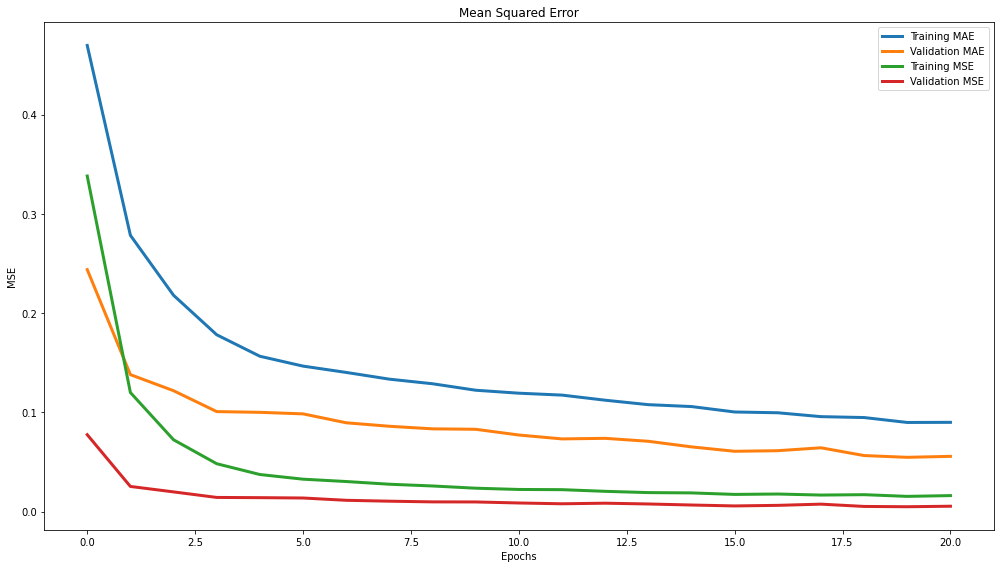

In [88]:
# plot loss graph

model_history = pd.DataFrame(history.history)
model_history['epoch'] = history.epoch

fig, ax = plt.subplots(figsize=(14,8))
num_epochs = model_history.shape[0]
ax.plot(np.arange(0, num_epochs), model_history["loss"], 
        label="Training MAE", lw=3)
ax.plot(np.arange(0, num_epochs), model_history["val_loss"], 
        label="Validation MAE", lw=3)
ax.plot(np.arange(0, num_epochs), model_history["mse"], 
        label="Training MSE", lw=3)
ax.plot(np.arange(0, num_epochs), model_history["val_mse"], 
        label="Validation MSE", lw=3)
plt.ylabel('MSE')
plt.xlabel('Epochs')
plt.title("Mean Squared Error")
ax.legend()
plt.tight_layout()
plt.show()

In [89]:
model.summary()

Model: "positional_ratings_predictor"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
first_hidden_layer (Dense)   (None, 36)                1656      
_________________________________________________________________
dropout_8 (Dropout)          (None, 36)                0         
_________________________________________________________________
final_hidden_layer (Dense)   (None, 32)                1184      
_________________________________________________________________
activation_4 (Activation)    (None, 32)                0         
_________________________________________________________________
dropout_9 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_4 (Dense)              (None, 26)                858       
Total params: 3,698
Trainable params: 3,698
Non-trainable params: 0
____________________________________

In [90]:
# get output of last dense hidden layer with training flag set to 0

import keras.backend as K

outputs = [model.get_layer('final_hidden_layer').output]
functor = K.function([model.input], outputs)
layer_outs = functor([df_preprocessed[feature_cols].values, 0])
df_embeddings = pd.DataFrame(np.array(layer_outs).reshape(6358,32))
df_embeddings.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31
0,0.098888,-0.018730,-0.132960,0.008572,-0.072785,0.113407,0.040542,-0.073642,0.047720,-0.201012,-0.075515,-0.167619,-0.014493,-0.029463,0.096723,0.043336,-0.081512,0.026765,0.097946,0.067187,0.029241,0.043772,0.117619,-0.085688,-0.180231,-0.141471,0.032998,0.109107,0.068421,-0.110338,0.047237,-0.148190
1,0.150163,0.058801,-0.146037,0.074920,0.062421,0.119012,0.071093,-0.110336,0.086393,-0.161803,-0.106808,-0.194391,0.094479,0.070196,0.125678,0.036484,-0.057232,0.082112,0.103580,0.107232,0.106655,0.058587,0.085961,-0.073605,-0.089336,-0.161194,0.075858,0.103367,0.101757,-0.073713,0.099040,-0.145002
2,0.109585,-0.045788,-0.141302,0.008358,-0.087123,0.154844,0.036263,-0.066735,0.042441,-0.197283,-0.102284,-0.141973,-0.041265,-0.049172,0.111243,0.047525,-0.125442,0.029884,0.097946,0.042612,0.034491,0.053075,0.149570,-0.079709,-0.190098,-0.146384,0.047569,0.112073,0.066627,-0.167139,0.043497,-0.119312
3,0.095147,-0.090690,-0.130869,-0.021235,-0.136777,0.172417,0.023485,-0.094813,0.036122,-0.241510,-0.107328,-0.155081,-0.084078,-0.090163,0.098271,0.059469,-0.141468,0.015914,0.111310,0.033963,0.027148,0.060263,0.160679,-0.079539,-0.224621,-0.117492,0.041772,0.122551,0.057194,-0.175876,0.030490,-0.179021
4,0.119317,0.097978,-0.131563,0.096871,0.087272,0.023734,0.082145,-0.052841,0.071903,-0.119228,-0.083451,-0.129607,0.105100,0.081324,0.067492,-0.020370,-0.042048,0.080071,0.049411,0.098574,0.105177,0.016748,-0.004429,-0.166377,-0.052734,-0.103495,0.092645,0.052771,0.069672,-0.018879,0.085028,-0.090481


In [91]:
# join embeddings df back onto nominal df

df_final = pd.concat([df_embeddings, df_nominal], axis=1)
df_final

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,id,player_fifa_api_id,player_api_id,date,player_name,player_positions,player_positions_general
0,0.098888,-0.018730,-0.132960,0.008572,-0.072785,0.113407,0.040542,-0.073642,0.047720,-0.201012,-0.075515,-0.167619,-0.014493,-0.029463,0.096723,0.043336,-0.081512,0.026765,0.097946,0.067187,0.029241,0.043772,0.117619,-0.085688,-0.180231,-0.141471,0.032998,0.109107,0.068421,-0.110338,0.047237,-0.148190,1,218353,505942,2016-02-18,Aaron Appindangoye,CB,DEF
1,0.150163,0.058801,-0.146037,0.074920,0.062421,0.119012,0.071093,-0.110336,0.086393,-0.161803,-0.106808,-0.194391,0.094479,0.070196,0.125678,0.036484,-0.057232,0.082112,0.103580,0.107232,0.106655,0.058587,0.085961,-0.073605,-0.089336,-0.161194,0.075858,0.103367,0.101757,-0.073713,0.099040,-0.145002,6,189615,155782,2016-04-21,Aaron Cresswell,LB,DEF
2,0.109585,-0.045788,-0.141302,0.008358,-0.087123,0.154844,0.036263,-0.066735,0.042441,-0.197283,-0.102284,-0.141973,-0.041265,-0.049172,0.111243,0.047525,-0.125442,0.029884,0.097946,0.042612,0.034491,0.053075,0.149570,-0.079709,-0.190098,-0.146384,0.047569,0.112073,0.066627,-0.167139,0.043497,-0.119312,65,140161,30572,2016-04-21,Aaron Galindo,"CB, RB",DEF
3,0.095147,-0.090690,-0.130869,-0.021235,-0.136777,0.172417,0.023485,-0.094813,0.036122,-0.241510,-0.107328,-0.155081,-0.084078,-0.090163,0.098271,0.059469,-0.141468,0.015914,0.111310,0.033963,0.027148,0.060263,0.160679,-0.079539,-0.224621,-0.117492,0.041772,0.122551,0.057194,-0.175876,0.030490,-0.179021,88,17725,23780,2015-12-24,Aaron Hughes,CB,DEF
4,0.119317,0.097978,-0.131563,0.096871,0.087272,0.023734,0.082145,-0.052841,0.071903,-0.119228,-0.083451,-0.129607,0.105100,0.081324,0.067492,-0.020370,-0.042048,0.080071,0.049411,0.098574,0.105177,0.016748,-0.004429,-0.166377,-0.052734,-0.103495,0.092645,0.052771,0.069672,-0.018879,0.085028,-0.090481,113,158138,27316,2016-04-28,Aaron Hunt,"CAM, CM, LM",MID
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6353,0.074431,0.116289,-0.175340,0.108144,0.103742,-0.053632,0.072020,-0.023802,0.051137,-0.111120,-0.041745,-0.121404,0.118806,0.077563,-0.020699,-0.086301,-0.012025,0.079453,0.005426,0.096583,0.100776,-0.019996,-0.094226,-0.190365,-0.048409,-0.112872,0.074650,-0.019840,0.050546,-0.035590,0.081411,-0.030351,183823,179712,107281,2016-01-21,Zoltan Stieber,"RM, LM, CAM",MID
6354,0.039375,-0.029534,-0.204848,-0.018328,-0.115096,0.008530,0.018655,-0.025226,0.009211,-0.267498,-0.017268,-0.290193,-0.023697,-0.052524,-0.047533,-0.033291,-0.020004,0.011328,0.054040,0.041810,0.009836,-0.010904,0.013777,-0.133775,-0.202334,-0.210804,-0.022020,0.003688,0.042338,-0.199369,0.026830,-0.074051,183857,219943,491794,2015-11-12,Zoran Josipovic,ST,ATK
6355,0.128044,0.099773,-0.181800,0.101307,0.090423,0.021981,0.082250,-0.105097,0.082158,-0.141187,-0.088391,-0.172692,0.118128,0.092629,0.057389,-0.040448,-0.035447,0.085901,0.051400,0.096972,0.118850,0.022059,-0.028027,-0.161939,-0.034681,-0.135938,0.086426,0.046645,0.071938,-0.052014,0.097500,-0.128483,183873,105454,99031,2016-05-05,Zoran Tosic,RM,MID
6356,0.037696,0.112264,-0.236330,0.092926,0.084303,-0.115713,0.056856,0.006905,0.016320,-0.168942,-0.028992,-0.201496,0.115688,0.059275,-0.116795,-0.135402,0.041862,0.072058,-0.033608,0.077797,0.084355,-0.063243,-0.183382,-0.234182,-0.093595,-0.168038,0.043301,-0.134228,0.028070,-0.126222,0.064923,0.027929,183896,195840,192132,2016-01-21,Zouhaier Dhaouadhi,"LM, LW",ATK


In [92]:
# perform ordinal encoding on player_positions_general column

# from sklearn.preprocessing import OrdinalEncoder

# df_subset = pd.concat([df_embeddings, df_nominal['player_positions_general']], axis=1)
# encoder = OrdinalEncoder()
# df_subset['label'] = encoder.fit_transform(np.array(df['player_positions_general']).reshape(-1,1))
# print(df_subset[['player_positions_general','label']])
# df_subset.drop(columns=['player_positions_general'], inplace=True)

In [93]:
# visualizing the embeddings

import seaborn as sns
from sklearn.manifold import TSNE

df_subset = pd.concat([df_embeddings, df_nominal['player_positions_general']], axis=1)

tsne = TSNE(n_components=2, verbose=1, perplexity=50, n_iter=300)
tsne_results = tsne.fit_transform(df_subset.iloc[:,:-1])

[t-SNE] Computing 151 nearest neighbors...
[t-SNE] Indexed 6358 samples in 0.021s...
[t-SNE] Computed neighbors for 6358 samples in 0.534s...
[t-SNE] Computed conditional probabilities for sample 1000 / 6358
[t-SNE] Computed conditional probabilities for sample 2000 / 6358
[t-SNE] Computed conditional probabilities for sample 3000 / 6358
[t-SNE] Computed conditional probabilities for sample 4000 / 6358
[t-SNE] Computed conditional probabilities for sample 5000 / 6358
[t-SNE] Computed conditional probabilities for sample 6000 / 6358
[t-SNE] Computed conditional probabilities for sample 6358 / 6358
[t-SNE] Mean sigma: 0.024305
[t-SNE] KL divergence after 250 iterations with early exaggeration: 65.638054
[t-SNE] KL divergence after 300 iterations: 1.685013


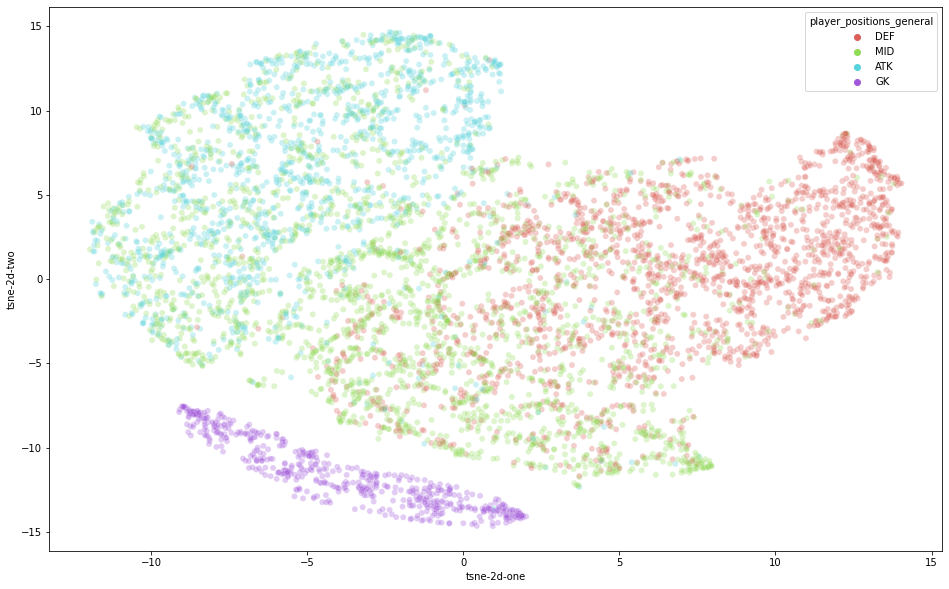

In [94]:
# plot tsne results on scatterplot, where ATK = 0, DEF = 1, GK = 2, MID = 3

df_subset['tsne-2d-one'] = tsne_results[:,0]
df_subset['tsne-2d-two'] = tsne_results[:,1]
plt.figure(figsize=(16,10))
sns.scatterplot(
    x="tsne-2d-one", y="tsne-2d-two",
    hue="player_positions_general",
    palette=sns.color_palette("hls", 4),
    data=df_subset,
    legend="full",
    alpha=0.3
)

In [95]:
# save embeddings df as csv

df_final.to_csv('/content/gdrive/My Drive/datasets/DNN_player_embeddings_(5,36,32).csv')